# Insper: Profa Maria Kelly Venezuela

# Ciência dos dados: Engenharias

# Projeto 3: PNADC - Uso dos microdados de 2023

# Grupo: Danilo Ramos, Leonardo Veras e Thomas Ganut
___


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from funcao import regress, pega_variaveis

import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization

from sklearn.model_selection import train_test_split # data split

from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm

from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric

sb.set_style('whitegrid') # plot style

___
## A. Introdução

### Objetivo escolhido:

O **tema** escolhido pelo grupo é como a classe social e a área de atuação podem determinar o salário de um indíviduo.
<br><br>

O ***df*** escolhido pelo grupo é "Qual era o rendimento bruto/retirada mensal que ... recebia/fazia normalmente nesse trabalho? (valor em dinheiro)" (variável V403312 - quantitativa).

O grupo dividiu as ***features*** escolhidas para o projeto em três temas, sendo estes "Classe social", "Área de atuação" e "Classificações gerais".

#### Classe social
- Cor ou raça (V2010)
- ... sabe ler e escrever? (V3001)
- A escola que ... frequenta é de (V3002A)
- Nível de instrução mais elevado alcançado (pessoas de 5 anos ou mais de idade) padronizado para o Ensino fundamental -  SISTEMA DE 9 ANOS (VD3004)

#### Área de atuação
- Nesse trabalho, ... tinha carteira de trabalho assinada? (V4029)

#### Classificações gerais
- Unidade da Federação (UF)
- Tipo de área (V1023)
- Idade do morador na data de referência (V2009)

___
# Leitura da base de dados - PNADC 2023:

In [15]:
df = pd.read_csv('output.csv')

print(len(df))

473335


In [16]:
# sns.pairplot(df)
# plt.tight_layout()
# plt.show()

In [17]:
# Mudando o tipo para 'category'
colunas = ['Estado', 'AreaRes', 'CorRaca', 'Analfabeto', 'Carteira', 'Instrucao']
for coluna in colunas:
    df[coluna] = df[coluna].astype('category')

# Renomeando as categorias
df['Estado'] = df['Estado'].cat.rename_categories({
    11: 'Rondônia', 12: 'Acre', 13: 'Amazonas', 14: 'Roraima', 15: 'Pará', 16: 'Amapá', 17: 'Tocantins', 
    21: 'Maranhão', 22: 'Piauí', 23: 'Ceará', 24: 'Rio Grande do Norte', 25: 'Paraíba', 26: 'Pernambuco', 27: 'Alagoas', 28: 'Sergipe', 29: 'Bahia', 
    31: 'Minas Gerais', 32: 'Espírito Santo', 33: 'Rio de Janeiro', 35: 'São Paulo', 
    41: 'Paraná', 42: 'Santa Catarina', 43: 'Rio Grande do Sul', 
    50: 'Mato Grosso do Sul', 51: 'Mato Grosso', 52: 'Goiás', 53: 'Distrito Federal'
})

df['AreaRes'] = df['AreaRes'].cat.rename_categories({
    1: 'Capital', 2: "Resto da RM", 3: 'Resto da RIDE', 4: 'Resto da UF' # RIDE = Região Integrada de Desenvolvimento Econômico
})

df['CorRaca'] = df['CorRaca'].cat.rename_categories({
    1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indigena', 9: 'Ignorado' 
})

df['Analfabeto'] = df['Analfabeto'].cat.rename_categories({
    1: 'Não', 2: 'Sim'
})

df['Carteira'] = df['Carteira'].cat.rename_categories({
    1: 'Sim', 2: 'Nao'
})

df['Instrucao'] = df['Instrucao'].cat.rename_categories({
    1: '<1 ano', 2: 'Fund. incompleto', 3: 'Fund. completo', 4: 'EM incompleto', 5: 'EM completo', 6: 'Sup. incompleto', 7: 'Sup. completo', 
})

# pd.Categorical
# df['Estado'] = pd.Categorical(df['Estado'], categories=[
#     'Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá', 'Tocantins', 'Maranhão', 
#     'Piauí', 'Ceará', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 
#     'Bahia', 'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo', 'Paraná', 
#     'Santa Catarina', 'Rio Grande do Sul', 'Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 
#     'Distrito Federal'
# ], ordered=False)

# df['AreaRes'] = pd.Categorical(df['AreaRes'], categories=[
#     'Capital', 'Resto da RM', 'Resto da RIDE', 'Resto da UF'
# ], ordered=False)

# df['CorRaca'] = pd.Categorical(df['CorRaca'], categories=[
#     'Branca', 'Preta', 'Amarela', 'Parda', 'Indigena', 'Ignorado'
# ], ordered=False)

# df['Analfabeto'] = pd.Categorical(df['Analfabeto'], categories=[
#     'Não', 'Sim'
# ], ordered=False)

# df['Carteira'] = pd.Categorical(df['Carteira'], categories=[
#     'Sim', 'Nao'
# ], ordered=False)

# df['Instrucao'] = pd.Categorical(df['Instrucao'], categories=[
#     '<1 ano', 'Fund. incompleto', 'Fund. completo', 'EM incompleto', 'EM completo', 
#     'Sup. incompleto', 'Sup. completo'
# ], ordered=True)

In [18]:
# Limita a idade entre 18 e 62 anos (maior de idade e não aposentado)
# Limpa os NaN das colunas 'Salario' e 'Carteira'
df = df.loc[(df['Idade'] >= 18) & (df['Idade'] < 62)].dropna(subset=['Salario', 'Carteira'])

# Define um df específico
df = df.loc[
    (df['Estado'].isin(['São Paulo', 'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'Paraná', 'Santa Catarina', 'Rio Grande do Sul'])) &
    (df['AreaRes'].isin(['Resto da RM', 'Capital'])) &
    (df['Instrucao'].isin(['EM completo', 'Sup. incompleto', 'Sup. completo']))
]

# Verifica se não tem NaN em nenhuma coluna
for coluna in colunas:
    print(f'{coluna}:', df[coluna].isna().sum())

print(f'\nQuantidade de pessoas no df: {len(df)}')

Estado: 0
AreaRes: 0
CorRaca: 0
Analfabeto: 0
Carteira: 0
Instrucao: 0

Quantidade de pessoas no df: 15531


In [19]:
# Filtre o DataFrame para manter apenas as categorias com contagem maior que zero
df = df[(df['Estado'].notna()) & (df['AreaRes'].notna()) & (df['Instrucao'].notna())]
df['Estado'] = df['Estado'].cat.remove_unused_categories()
df['AreaRes'] = df['AreaRes'].cat.remove_unused_categories()
df['Instrucao'] = df['Instrucao'].cat.remove_unused_categories()

# Verifique as categorias restantes
print(df['Estado'].cat.categories)


Index(['Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo',
       'Paraná', 'Santa Catarina', 'Rio Grande do Sul'],
      dtype='object')


In [20]:
dummies = pd.get_dummies(df.drop(columns=['Salario']), dtype=int)
df = pd.concat([df, dummies], axis=1)

Y = df['Salario']
X = dummies

X = sm.add_constant(X)

modelo = sm.OLS(Y, X)
resumo = modelo.fit()

df


,Estado,AreaRes,Idade,CorRaca,Analfabeto,Carteira,Salario,Instrucao,Idade,Estado_Minas Gerais,...,CorRaca_Parda,CorRaca_Indigena,CorRaca_Ignorado,Analfabeto_Não,Analfabeto_Sim,Carteira_Sim,Carteira_Nao,Instrucao_EM completo,Instrucao_Sup. incompleto,Instrucao_Sup. completo
224398,Minas Gerais,Capital,27,Parda,Não,Sim,1302.0,Sup. incompleto,27,1,...,1,0,0,1,0,1,0,0,1,0
224401,Minas Gerais,Capital,39,Branca,Não,Nao,800.0,Sup. incompleto,39,1,...,0,0,0,1,0,0,1,0,1,0
224417,Minas Gerais,Capital,45,Parda,Não,Nao,1302.0,EM completo,45,1,...,1,0,0,1,0,0,1,1,0,0
224418,Minas Gerais,Capital,22,Parda,Não,Sim,1302.0,Sup. incompleto,22,1,...,1,0,0,1,0,1,0,0,1,0
224420,Minas Gerais,Capital,37,Parda,Não,Nao,2000.0,EM completo,37,1,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426598,Rio Grande do Sul,Capital,42,Preta,Não,Nao,2000.0,Sup. completo,42,0,...,0,0,0,1,0,0,1,0,0,1
426625,Rio Grande do Sul,Resto da RM,18,Parda,Não,Nao,2000.0,EM completo,18,0,...,1,0,0,1,0,0,1,1,0,0
426626,Rio Grande do Sul,Resto da RM,34,Branca,Não,Sim,8000.0,Sup. completo,34,0,...,0,0,0,1,0,1,0,0,0,1
426630,Rio Grande do Sul,Resto da RM,59,Branca,Não,Nao,1800.0,EM completo,59,0,...,0,0,0,1,0,0,1,1,0,0


In [21]:
from funcao import regress, pega_variaveis

X_final = pega_variaveis(Y, X, 0.1)
results = regress(Y, X_final)

X_final

,Idade,Estado_São Paulo,AreaRes_Capital,AreaRes_Resto da RM,CorRaca_Branca,CorRaca_Preta,Analfabeto_Sim,Carteira_Sim,Instrucao_EM completo,Instrucao_Sup. incompleto,Instrucao_Sup. completo
224398,27,0,1,0,0,0,0,1,0,1,0
224401,39,0,1,0,1,0,0,0,0,1,0
224417,45,0,1,0,0,0,0,0,1,0,0
224418,22,0,1,0,0,0,0,1,0,1,0
224420,37,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
426598,42,0,1,0,0,1,0,0,0,0,1
426625,18,0,0,1,0,0,0,0,1,0,0
426626,34,0,0,1,1,0,0,1,0,0,1
426630,59,0,0,1,1,0,0,0,1,0,0


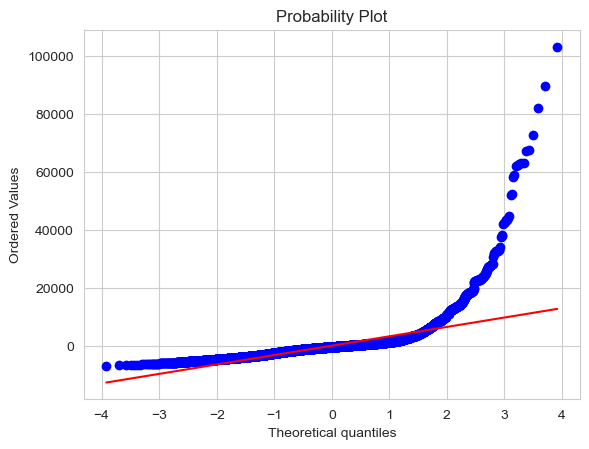

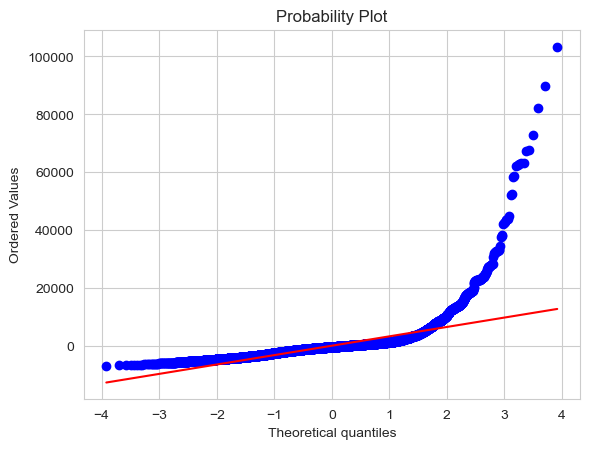

In [22]:
results = regress(Y, X)
stats.probplot(results.resid, dist='norm', plot=plt)
plt.show()

results = regress(Y, X_final)
stats.probplot(results.resid, dist='norm', plot=plt)
plt.show()

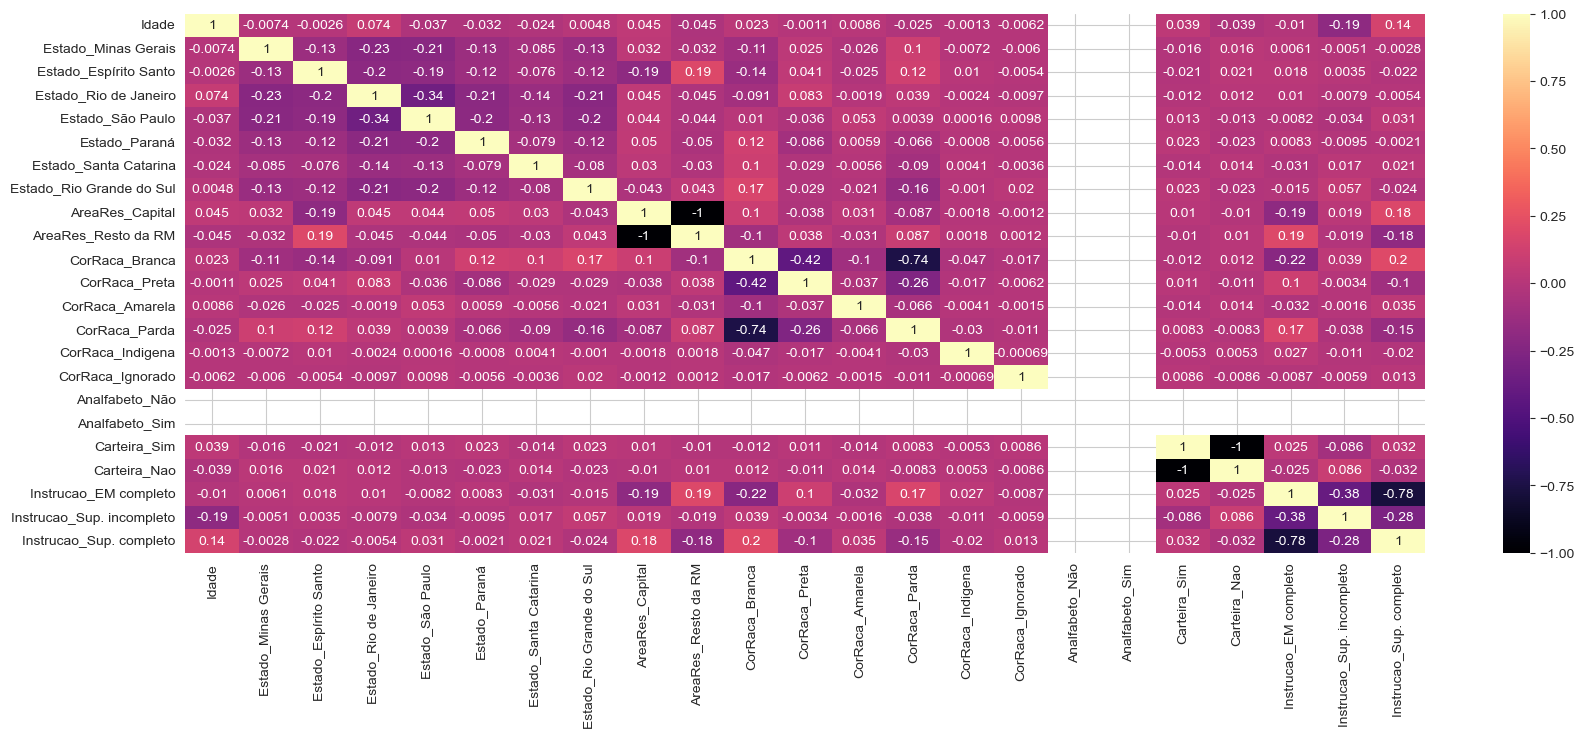

In [23]:
plt.figure(figsize=(20, 7))
sb.heatmap(dummies.corr(), annot = True, cmap = 'magma')
plt.show()

In [24]:
X_var = X_final.values
Y_var = Y.values

X_train, X_test, Y_train, Y_test = train_test_split(X_var, Y_var, random_state = 0)

print('X_train samples:', X_train[0:5])
print('X_test samples:', X_test[0:5])
print('Y_train samples:', Y_train[0:5])
print('Y_test samples:', Y_test[0:5])

X_train samples: [[38  0  0  1  0  0  0  0  1  0  0]
 [21  0  1  0  0  0  0  1  1  0  0]
 [26  0  1  0  1  0  0  1  0  0  1]
 [37  0  1  0  1  0  0  1  1  0  0]
 [33  1  1  0  1  0  0  0  1  0  0]]
X_test samples: [[40  0  0  1  0  1  0  1  0  1  0]
 [37  1  1  0  1  0  0  1  0  0  1]
 [18  0  0  1  1  0  0  1  1  0  0]
 [20  0  1  0  1  0  0  0  0  1  0]
 [43  0  0  1  1  0  0  1  0  0  1]]
Y_train samples: [3000. 1600. 2800. 1900. 1700.]
Y_test samples: [ 5500. 15000.  1500.  1302.  4000.]


In [25]:
# MODELING

# 1. OLS

ols = LinearRegression()
ols.fit(X_train, Y_train)
ols_yhat = ols.predict(X_test)

# 2. Ridge

ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, Y_train)
ridge_yhat = ridge.predict(X_test)

# 3. Lasso

lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, Y_train)
lasso_yhat = lasso.predict(X_test)

# 4. Bayesian

bayesian = BayesianRidge()
bayesian.fit(X_train, Y_train)
bayesian_yhat = bayesian.predict(X_test)

# 5. ElasticNet

en = ElasticNet(alpha = 0.01)
en.fit(X_train, Y_train)
en_yhat = en.predict(X_test)

In [26]:
# 1. Explained Variance Score
print('EXPLAINED VARIANCE SCORE:')
print('-------------------------------------------------------------------------------')
print('Explained Variance Score of OLS model is {}'.format(evs(Y_test, ols_yhat)))
print('-------------------------------------------------------------------------------')
print('Explained Variance Score of Ridge model is {}'.format(evs(Y_test, ridge_yhat)))
print('-------------------------------------------------------------------------------')
print('Explained Variance Score of Lasso model is {}'.format(evs(Y_test, lasso_yhat)))
print('-------------------------------------------------------------------------------')
print('Explained Variance Score of Bayesian model is {}'.format(evs(Y_test, bayesian_yhat)))
print('-------------------------------------------------------------------------------')
print('Explained Variance Score of ElasticNet is {}'.format(evs(Y_test, en_yhat)))
print('-------------------------------------------------------------------------------')

# 2. R-squared
print('R-SQUARED:')
print('-------------------------------------------------------------------------------')
print('R-Squared of OLS model is {}'.format(r2(Y_test, ols_yhat)))
print('-------------------------------------------------------------------------------')
print('R-Squared of Ridge model is {}'.format(r2(Y_test, ridge_yhat)))
print('-------------------------------------------------------------------------------')
print('R-Squared of Lasso model is {}'.format(r2(Y_test, lasso_yhat)))
print('-------------------------------------------------------------------------------')
print('R-Squared of Bayesian model is {}'.format(r2(Y_test, bayesian_yhat)))
print('-------------------------------------------------------------------------------')
print('R-Squared of ElasticNet is {}'.format(r2(Y_test, en_yhat)))
print('-------------------------------------------------------------------------------')

EXPLAINED VARIANCE SCORE:
-------------------------------------------------------------------------------
Explained Variance Score of OLS model is 0.208585252294895
-------------------------------------------------------------------------------
Explained Variance Score of Ridge model is 0.2085896107046218
-------------------------------------------------------------------------------
Explained Variance Score of Lasso model is 0.2085853731640075
-------------------------------------------------------------------------------
Explained Variance Score of Bayesian model is 0.20873255583413464
-------------------------------------------------------------------------------
Explained Variance Score of ElasticNet is 0.20904867906996105
-------------------------------------------------------------------------------
R-SQUARED:
-------------------------------------------------------------------------------
R-Squared of OLS model is 0.20677133314114626
----------------------------------------------

In [27]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import svm
from sklearn.svm import SVC

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))

0.5142228542856707


In [28]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_test)

mean_absolute_percentage_error(Y_test, Y_pred)

0.7319606893861227

In [29]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))

0.7832819670417014


In [30]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

cb_model = CatBoostRegressor()
cb_model.fit(X_train, Y_train)
preds = cb_model.predict(X_test) 

cb_r2_score=r2_score(Y_test, preds)
cb_r2_score

Learning rate set to 0.060346
0:	learn: 4887.0297415	total: 151ms	remaining: 2m 31s
1:	learn: 4832.7913199	total: 162ms	remaining: 1m 20s
2:	learn: 4791.7348704	total: 170ms	remaining: 56.3s
3:	learn: 4745.1836904	total: 181ms	remaining: 45s
4:	learn: 4704.9350081	total: 189ms	remaining: 37.7s
5:	learn: 4664.8928123	total: 206ms	remaining: 34.1s
6:	learn: 4632.6035072	total: 221ms	remaining: 31.3s
7:	learn: 4601.6741113	total: 233ms	remaining: 28.9s
8:	learn: 4574.0808012	total: 244ms	remaining: 26.9s
9:	learn: 4552.9647400	total: 253ms	remaining: 25s
10:	learn: 4533.0108289	total: 261ms	remaining: 23.5s
11:	learn: 4512.1403033	total: 273ms	remaining: 22.5s
12:	learn: 4494.0338083	total: 284ms	remaining: 21.6s
13:	learn: 4476.1818060	total: 296ms	remaining: 20.8s
14:	learn: 4461.0718257	total: 306ms	remaining: 20.1s
15:	learn: 4448.9920200	total: 319ms	remaining: 19.6s
16:	learn: 4436.4967743	total: 330ms	remaining: 19.1s
17:	learn: 4428.8909012	total: 336ms	remaining: 18.3s
18:	learn:

0.1640354973787017